In [1]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from models import SIR_stochastic, SEIR_stochastic, plot_samples
import util

# Run Inference

In [4]:
world_data = util.load_world_data()
state_data = util.load_state_data()
data = dict(world_data, **state_data)  # all data

model = 'SEIR'
prob_model = SEIR_stochastic

save = True

#places = state_data.keys()
#places = ['Italy', 'US', 'WA', 'NY', 'MA']
#places = ['NY']
#places = ['US']
#places = ['LA']
places = ['NY', 'WA']

for place in places:

    print(f"******* {place} *********")
    
    start = pd.Timestamp('2020-03-04')
    confirmed = data[place]['data'].confirmed[start:]
    start = confirmed.index.min()

    T = len(confirmed)
    N = data[place]['pop']

    args = {
        'N': N,
        'T': T,
        'rw_scale': 2e-1,
        'det_conc': 10,
    }

    kernel = NUTS(prob_model,
                  init_strategy = numpyro.infer.util.init_to_median())

    mcmc = MCMC(kernel, 
                num_warmup=1000, 
                num_samples=1000, 
                num_chains=1)

    print("Running MCMC")
    mcmc.run(jax.random.PRNGKey(2), 
             obs = confirmed.values,
             **args)

    mcmc.print_summary()
    mcmc_samples = mcmc.get_samples()
    
    # Prior samples for comparison
    prior = Predictive(prob_model, posterior_samples = {}, num_samples = 1000)
    prior_samples = prior(PRNGKey(2), **args)

    # Posterior predictive samples for visualization
    args['drift_scale'] = 0 # set drift to zero for forecasting
    post_pred = Predictive(prob_model, posterior_samples = mcmc_samples)
    post_pred_samples = post_pred(PRNGKey(2), T_future=100, **args)

    if save:
        util.save_samples(place,
                         prior_samples,
                         mcmc_samples, 
                         post_pred_samples)
        
        util.write_summary(place, mcmc)

******* NY *********
Running MCMC


sample: 100%|██████████| 2000/2000 [01:37<00:00, 20.58it/s, 205 steps of size 2.02e-02. acc. prob=0.84] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        E0    153.54     89.02    131.66     50.79    266.73    205.46      1.01
        I0     13.44      6.84     11.55      5.26     22.25    359.99      1.00
   beta[0]      1.52      0.77      1.36      0.48      2.55    314.60      1.01
   beta[1]      1.51      0.72      1.35      0.45      2.46    379.94      1.00
   beta[2]      1.51      0.71      1.36      0.53      2.45    425.59      1.00
   beta[3]      1.52      0.72      1.35      0.59      2.39    392.25      1.00
   beta[4]      1.57      0.77      1.39      0.58      2.50    381.33      1.00
   beta[5]      1.67      0.81      1.48      0.57      2.62    335.17      1.00
   beta[6]      1.84      0.93      1.62      0.70      2.95    323.00      1.00
   beta[7]      2.04      1.04      1.79      0.83      3.31    296.14      1.00
   beta[8]      2.28      1.16      2.04      0.89      3.63    324.28      1.00
   beta[9]      2.54      1

sample: 100%|██████████| 2000/2000 [01:26<00:00, 23.10it/s, 31 steps of size 2.90e-02. acc. prob=0.83]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        E0    190.44    161.90    158.91      1.12    380.55    335.09      1.00
        I0     78.45     22.08     75.09     48.79    106.97    263.49      1.01
   beta[0]      1.28      0.70      1.14      0.30      2.22    214.92      1.00
   beta[1]      1.29      0.66      1.12      0.43      2.37    263.35      1.00
   beta[2]      1.32      0.64      1.18      0.44      2.42    338.88      1.00
   beta[3]      1.38      0.65      1.24      0.47      2.39    384.32      1.00
   beta[4]      1.41      0.65      1.32      0.51      2.38    413.03      1.00
   beta[5]      1.43      0.65      1.31      0.55      2.40    486.25      1.00
   beta[6]      1.42      0.64      1.29      0.50      2.36    471.11      1.00
   beta[7]      1.40      0.64      1.27      0.42      2.24    441.40      1.00
   beta[8]      1.33      0.60      1.23      0.46      2.10    439.91      1.00
   beta[9]      1.27      0

NY


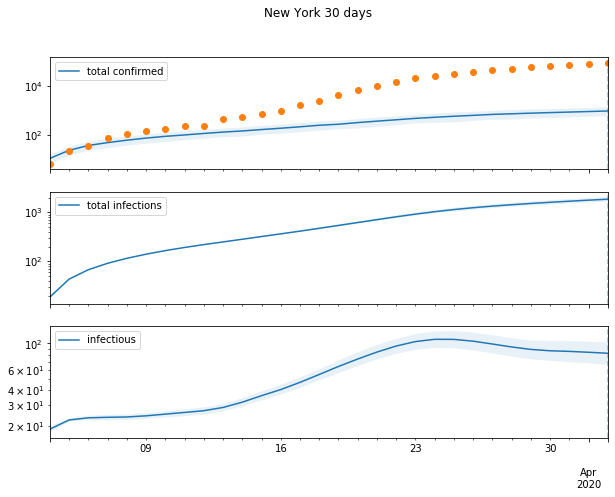

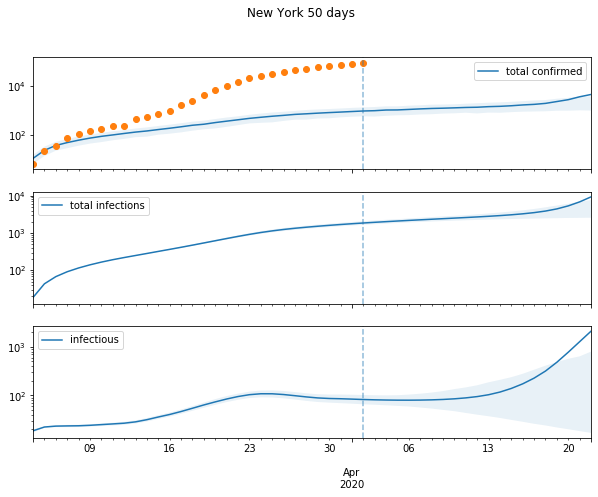

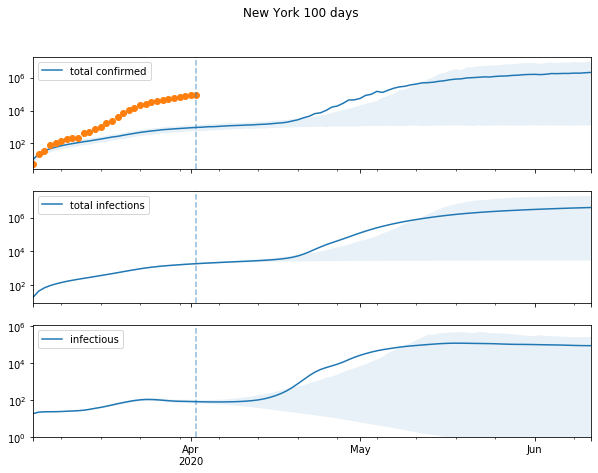

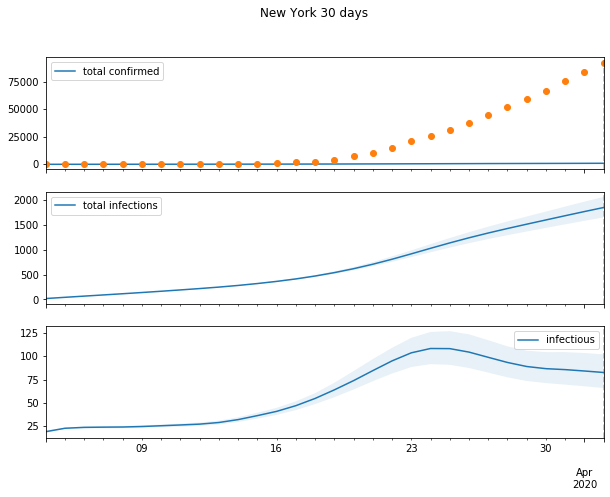

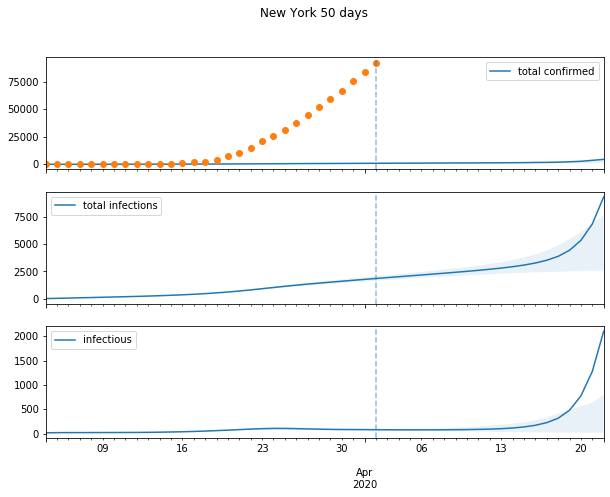

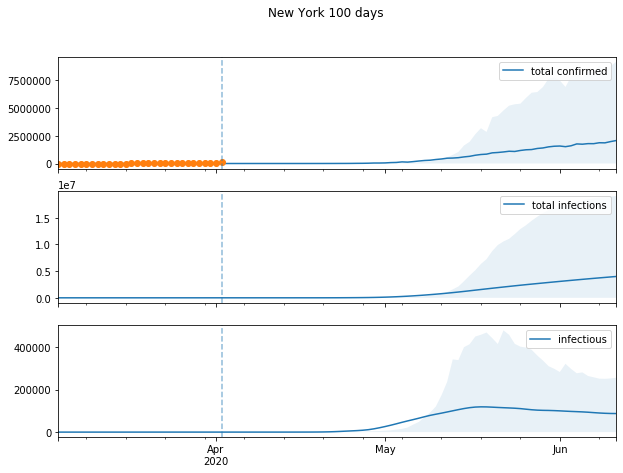

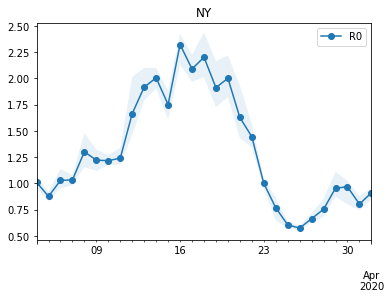

WA


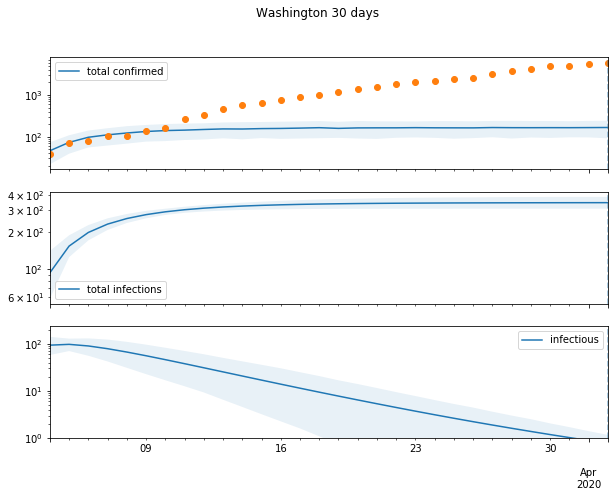

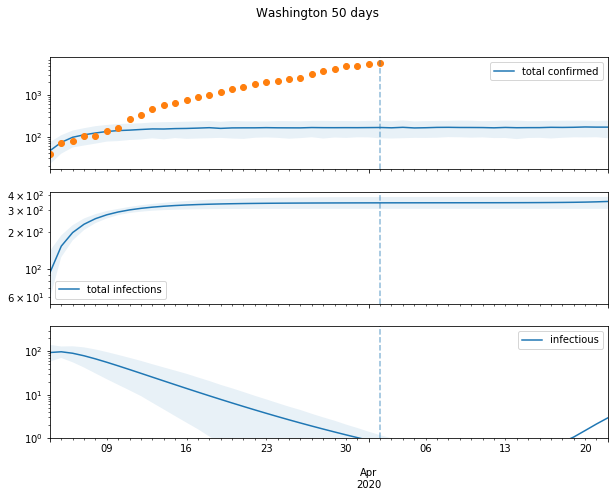

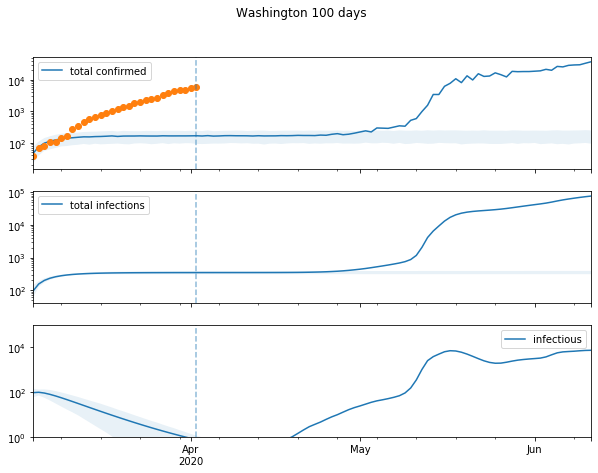

KeyboardInterrupt: 

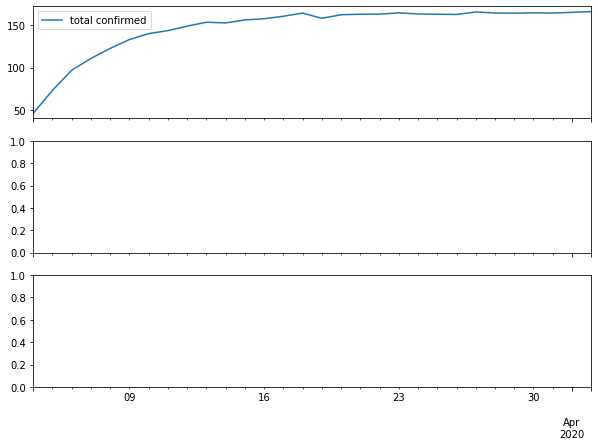

In [3]:
world_data = util.load_world_data()
state_data = util.load_state_data()
data = dict(world_data, **state_data)  # all data

start = '2020-03-04'
#places = ['Italy', 'US', 'WA', 'NY', 'MA']
#places = ['ID']
#places = ['NY', 'WA']
places = state_data.keys()
#places = ['AK']
#places = ['US']
#places = ['LA']

model = 'SEIR'

save = True

for place in places:
    
    print(place)
    confirmed = data[place]['data'].confirmed[start:]
    start_ = confirmed.index.min()

    T = len(confirmed)
    N = data[place]['pop']

    prior_samples, mcmc_samples, post_pred_samples = util.load_samples(place)
    
    # Inspect and Save Results    
    for scale in ['log', 'lin']:
        for T in [30, 50, 100]:

            t = pd.date_range(start=start_, periods=T, freq='D')
            
            fig, ax = plt.subplots(nrows=3, figsize=(10,7), sharex=True)

            plot_samples(post_pred_samples, T=T, t=t, ax=ax[0], plot_fields=['y'], model=model)
            confirmed.plot(ax=ax[0], style='o')

            plot_samples(post_pred_samples, T=T, t=t, ax=ax[1], plot_fields=['C'], model=model)

            plot_samples(post_pred_samples, T=T, t=t, ax=ax[2], plot_fields=['I'], model=model)

            [a.axvline(confirmed.index.max(), linestyle='--', alpha=0.5) for a in ax]

            name = data[place]['name']
            plt.suptitle(f'{name} {T} days ')
            
            if scale == 'log':
                for a in ax:
                    a.set_yscale('log')
                    
                    # Don't display below 1
                    bottom, top = a.get_ylim()
                    bottom = 1 if bottom < 1 else bottom
                    a.set_ylim(bottom=bottom)
                
            if save:
                filename = f'vis/{place}_predictive_scale_{scale}_T_{T}.png'
                plt.savefig(filename)

            plt.show()

    # Compute average R0 over time
    gamma = mcmc_samples['gamma'][:,None]
    beta = mcmc_samples['beta']
    t = pd.date_range(start=start_, periods=beta.shape[1], freq='D')
    R0 = beta/gamma

    pi = np.percentile(R0, (10, 90), axis=0)
    df = pd.DataFrame(index=t, data={'R0': np.median(R0, axis=0)})
    df.plot(style='-o')
    plt.fill_between(t, pi[0,:], pi[1,:], alpha=0.1)

    if save:
        filename = f'vis/{place}_R0.png'
        plt.savefig(filename)

    plt.title(place)
    plt.show()

In [ ]:
import seaborn as sns

cols = ['gamma', 'beta0', 'sigma', 'det_rate']

def get_cols(d):
    return {k: v for k, v in d.items() if k in cols}

prior_df = pd.DataFrame(get_cols(prior_samples))
posterior_df = pd.DataFrame(get_cols(mcmc_samples))

prior_df['dist'] = 'prior'
posterior_df['dist'] = 'posterior'

# Visualize priors
fig, ax = plt.subplots(ncols=len(cols), figsize=(16,3))
for i in range(len(cols)):
    sns.kdeplot(prior_df[cols[i]], ax=ax[i], shade=True)
    ax[i].set_title(cols[i])
    plt.suptitle('Priors')
plt.show()
    

# Compare posterior to prior
df = pd.concat([prior_df, posterior_df])
g = sns.PairGrid(df, hue='dist', diag_sharey=False, vars=['beta0', 'gamma', 'sigma'])
g = g.map_diag(sns.kdeplot, shade=True)
g = g.map_upper(plt.scatter, s=0.1, alpha=0.5)
g = g.map_lower(sns.kdeplot, n_levels=5, shade=True, shade_lowest=False, alpha=0.6)
g = g.add_legend()
plt.show()

# Compare gamma and beta0 specifically
fig, ax = plt.subplots(figsize=(9,4), ncols=2)

xlim = [0, 6]
ylim = [0, 3]

for df, name, a in zip([prior_df, posterior_df], ['Prior', 'Posterior'], ax):
    sns.kdeplot(df['beta0'], 
                df['gamma'], 
                ax=a,
                shade=True, 
                shade_lowest=False)
    a.set_title(name)
    a.set_xlim(xlim)
    a.set_ylim(ylim)

plt.show()

In [ ]:
samples = post_pred_samples
X = np.concatenate((samples['x'], samples['x_future']), axis=1)

T = X.shape[1]
t = pd.date_range(start, freq='D', periods=T)
levels = 10

beta0 = mcmc_samples['beta0']
gamma = mcmc_samples['gamma']
inds = np.argsort(beta0)
level_inds = inds[np.linspace(0, len(I)-1, levels).astype('int32')]

fig, ax = plt.subplots(figsize=(12,14), nrows=5)


beta0_gamma = [f'({beta0[i]:.2f}, {gamma[i]:.2f})' for i in level_inds]

for col, name, a in zip([0, 1, 2, 3, 4], 
                       ['susceptible', 'exposed', 'infectious', 'removed', 'cum. infected'],
                       ax):

    X_levels = np.squeeze(X[level_inds,:,col].T)

    lines = []
    cmap = plt.cm.cool
    for i in range(levels):
        lines += a.plot(t, X_levels[:,i], color=cmap(i*30))

    a.set_title(name)
    
plt.legend(beta0_gamma)

plt.show()

In [ ]:
n = 50
for i in range(n):
    print(plt.cm.jet(i * n / 256))

In [ ]:
sns.distplot(df['beta0'], hist=False, kde_kws={'shade': True})

In [ ]:
from compartment import SIRModel, SEIRModel

save = False

beta = mcmc_samples['beta0']
#gamma = np.broadcast_to(mcmc_samples['gamma'][:,None], beta.shape)
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SEIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['sigma'],
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('growth rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

In [ ]:
def test_prior(i, log_scale=False, **kwargs):
    with numpyro.handlers.seed(rng_seed=i):
        beta, x, y, obs_rate = SEIR_stochastic(**kwargs)
        
    T = len(x)
    ts = np.arange(T)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    l1 = ax1.plot(ts, x[:,1:])    
    l2 = ax2.plot(ts, y, 'x', color='r')
        
    plt.legend(l1 + l2, ['I', 'R', 'C', 'y'])
    
    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    
    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )
    
    plt.show()

def test_prior_predictive():
    T = 100
    T_future = 100
    N = 1e6
    predictive = Predictive(SEIR_stochastic, 
                            posterior_samples = {}, 
                            num_samples=100)

    samples = predictive(PRNGKey(2), T=T, T_future=100, N=N, det_conc=200)

    plot_samples(samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
    
    return samples
    
run_tests = True
    
if run_tests:
    for i in range(5):
        test_prior(i, log_scale=False, T=100, T_future=100, N=1e7, det_conc=10)
        
#    samples = test_prior_predictive()

In [ ]:
# Observation distribution
conc = 10

x = np.linspace(0, 1, 1000)

for N in ([10, 100, 1e4, 1e5, 1e6, 1e6, 1e8]):
    
    adj_conc = conc * N**0.2 * 10
    
    for p in np.linspace(0.01, 0.99, 10):
        d = dist.Beta(adj_conc*p, adj_conc*(1-p))
        plt.plot(N*x, np.exp(d.log_prob(x)))
    
    plt.show()


In [ ]:
data['CA']['data']